Automatic correspondences matching.

Goal
In this chapter,

We will mix up the feature matching and findHomography from calib3d module to find known objects in a complex image.
Basics
So what we did in last session? We used a queryImage, found some feature points in it, we took another trainImage, found the features in that image too and we found the best matches among them. In short, we found locations of some parts of an object in another cluttered image. This information is sufficient to find the object exactly on the trainImage.

For that, we can use a function from calib3d module, ie cv.findHomography(). If we pass the set of points from both the images, it will find the perspective transformation of that object. Then we can use cv.perspectiveTransform() to find the object. It needs atleast four correct points to find the transformation.

We have seen that there can be some possible errors while matching which may affect the result. To solve this problem, algorithm uses RANSAC or LEAST_MEDIAN (which can be decided by the flags). So good matches which provide correct estimation are called inliers and remaining are called outliers. cv.findHomography() returns a mask which specifies the inlier and outlier points.

So let's do it !!!

Code

First, as usual, let's find SIFT features in images and apply the ratio test to find the best matches.

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img1 = cv.imread('hg_2_2.jpg',0)          # queryImage
img2 = cv.imread('hg_2_8.jpg',0)          # trainImage

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
print(len(good))

3283


Now we set a condition that atleast 10 matches (defined by MIN_MATCH_COUNT) are to be there to find the object. Otherwise simply show a message saying not enough matches are present.

If enough matches are found, we extract the locations of matched keypoints in both the images. They are passed to find the perspective transformation. Once we get this 3x3 transformation matrix, we use it to transform the corners of queryImage to corresponding points in trainImage. Then we draw it.

In [2]:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    print(len(src_pts))
    
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    print(M)
    
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)

3283
[[ 6.53453067e-01  2.06501669e-01 -5.51251650e+00]
 [-2.02967609e-01  6.57965961e-01  9.85007522e+02]
 [ 1.24191783e-06 -2.13203451e-07  1.00000000e+00]]


Finally we draw our inliers (if successfully found the object) or matching keypoints (if failed).

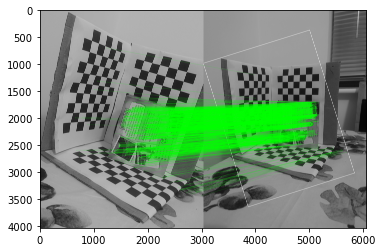

(<matplotlib.image.AxesImage at 0x2148083d9d0>, None)

In [3]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,(0,255,0),**draw_params)
plt.imshow(img3, 'gray'),plt.show()

In [4]:
# Radius of circle
radius = 2
  
# Blue color in BGR
color = (0, 255, 0)
  
# Line thickness of 2 px
thickness = 1
  
# Using cv2.circle() method
# Draw a circle with blue line borders of thickness of 2 px
#image = cv2.circle(image, center_coordinates, radius, color, thickness)
for p1 in kp1:
    img4=cv.circle(img1, p1, radius, color, thickness)
plt.imshow(img4, 'gray'),plt.show()

SystemError: new style getargs format but argument is not a tuple